- References  
    - https://iai.postech.ac.kr/tutorials  
    - https://i-systems.github.io/tutorial/KSME/Advanced/220119/04_02_GradCAM.html
    - https://brave-greenfrog.tistory.com/47

In [22]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from PIL import Image


In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image

# TensorFlow가 GPU를 사용할 수 있는지 확인합니다.
print("TensorFlow 버전:", tf.__version__)
print("GPU 사용 가능:", tf.test.is_gpu_available())

# 사용 가능한 GPU 목록을 출력합니다.
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # 필요한 경우 메모리 증가를 허용합니다.
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    print("사용 가능한 GPU:", gpus)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가를 설정해야만 합니다.
    print(e)
else:
  print("GPU를 찾을 수 없습니다. CPU를 사용합니다.")

TensorFlow 버전: 2.10.0
GPU 사용 가능: True
사용 가능한 GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [24]:
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)  # PyTorch의 CPU 난수 시드 고정
    # if torch.cuda.is_available():
        # torch.cuda.manual_seed_all(seed)
    
set_seeds(42)

In [25]:
mnist = tf.keras.datasets.mnist

(train_x, train_y), (test_x, test_y) = mnist.load_data()

# using 3000 data for test
train_x=train_x[:3000]
train_y=train_y[:3000]

# using 1000 data for test
test_x=test_x[:1000]
test_y=test_y[:1000]

train_x, test_x = train_x/255.0, test_x/255.0

train_x = train_x.reshape((train_x.shape[0], 28, 28, 1))
test_x = test_x.reshape((test_x.shape[0], 28, 28, 1))

n_train = train_x.shape[0]
n_test = test_x.shape[0]

print ("The number of training images : {}, shape : {}".format(n_train, train_x.shape))
print ("The number of testing images : {}, shape : {}".format(n_test, test_x.shape))

The number of training images : 3000, shape : (3000, 28, 28, 1)
The number of testing images : 1000, shape : (1000, 28, 28, 1)


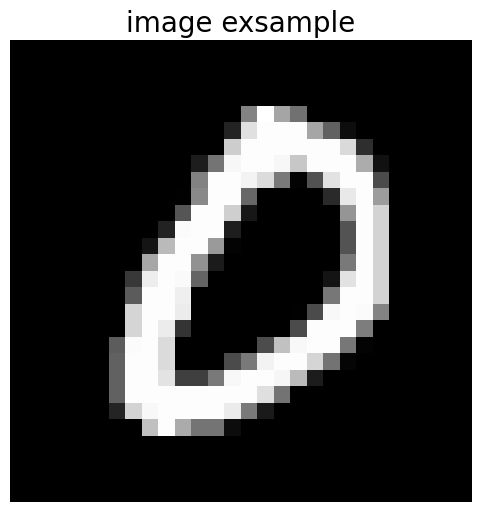

In [26]:
idx = np.random.randint(n_train)
plt.figure(figsize = (8,6))
plt.imshow(train_x[idx][:,:,0], 'gray')
plt.title('image exsample', fontsize = 20)
plt.axis('off')
plt.show()

In [27]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 32,
                          kernel_size = (3, 3),
                          activation = 'relu',
                          padding = 'SAME',
                          input_shape = (28, 28, 1)),
    tf.keras.layers.MaxPool2D((2, 2)),
    
    tf.keras.layers.Conv2D(filters = 64,
                          kernel_size = (3, 3),
                          activation = 'relu',
                          padding = 'SAME',
                          input_shape = (14, 14, 32)),
    
    tf.keras.layers.MaxPool2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 32, activation = 'relu'),
    tf.keras.layers.Dense(units = 10, activation = 'softmax')
])

In [28]:
model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = 'accuracy')

In [29]:
history=model.fit(train_x, train_y, 
                  epochs = 100, 
                  batch_size = 64)

Epoch 1/100
47/47 [==============================] - 0s 6ms/step - loss: 1.1833 - accuracy: 0.6527
Epoch 2/100
47/47 [==============================] - 0s 2ms/step - loss: 0.3472 - accuracy: 0.9010
Epoch 3/100
47/47 [==============================] - 0s 2ms/step - loss: 0.2169 - accuracy: 0.9387
Epoch 4/100
47/47 [==============================] - 0s 2ms/step - loss: 0.1550 - accuracy: 0.9557
Epoch 5/100
47/47 [==============================] - 0s 2ms/step - loss: 0.1234 - accuracy: 0.9687
Epoch 6/100
47/47 [==============================] - 0s 1ms/step - loss: 0.0870 - accuracy: 0.9750
Epoch 7/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0720 - accuracy: 0.9790
Epoch 8/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0581 - accuracy: 0.9857
Epoch 9/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0437 - accuracy: 0.9880
Epoch 10/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0384 - accuracy: 0.9893
Epoch 11/

In [30]:
model.evaluate(test_x, test_y)

32/32 [==============================] - 0s 1ms/step - loss: 0.1674 - accuracy: 0.9650


[0.1673889011144638, 0.9649999737739563]

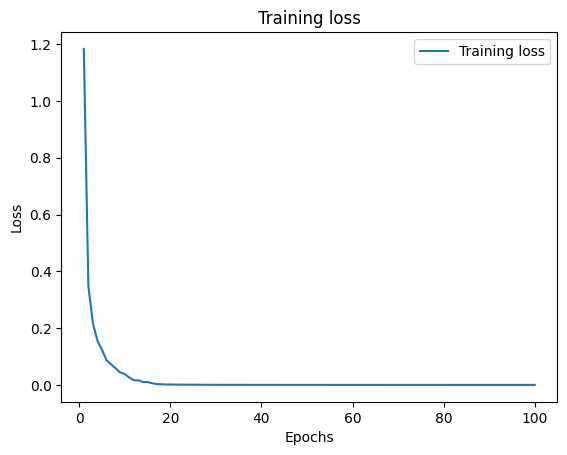

In [31]:
import matplotlib.pyplot as plt
loss = history.history["loss"]

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, label="Training loss")
plt.title("Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

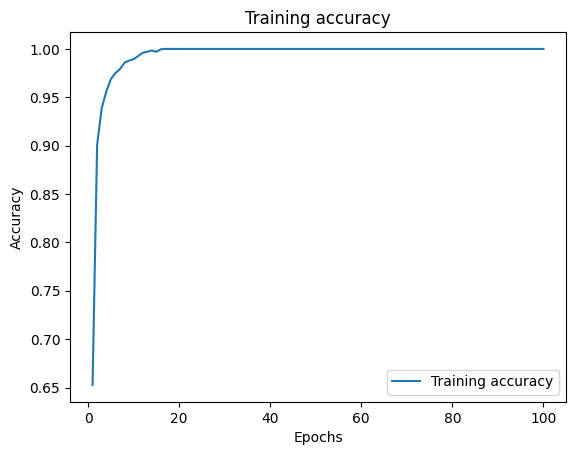

In [32]:
plt.clf()
acc = history.history["accuracy"]

plt.plot(epochs, acc, label="Training accuracy")

plt.title("Training accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

1/1 [==============================] - 0s 34ms/step


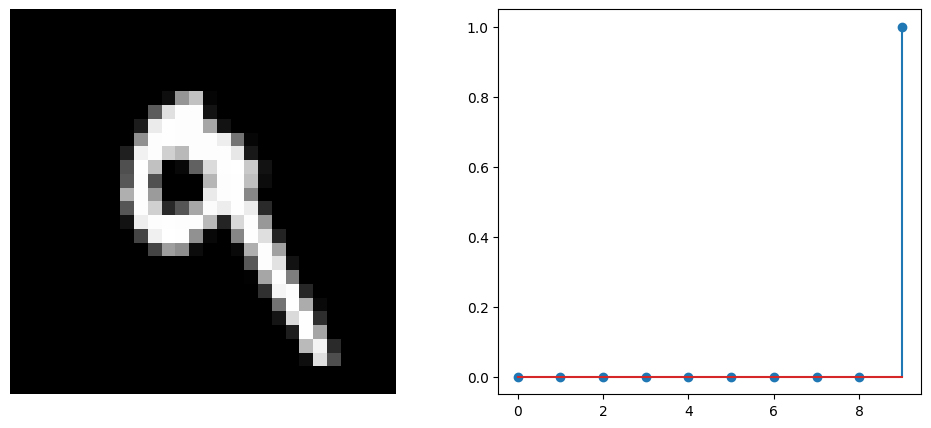

True : 9
Prediction : 9


In [33]:
test_idx = [7]
test_img = test_x[test_idx]
test_true = test_y[test_idx]

predict = model.predict(test_img)
mypred = np.argmax(predict, axis = 1)

plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.imshow(test_img.reshape(28, 28), 'gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.stem(predict[0])
plt.show()

print('True : {}'.format(test_true[0]))
print('Prediction : {}'.format(mypred[0]))

# GradCAM

In [139]:
def make_gradcam_heatmap(img_array, model, conv_layer_idx, pred_index=None):
    # 입력에 따른 피처 맵 모델 생성
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(index=conv_layer_idx).output, model.output]
    )
    
    #출력에 따른 Gradient 계산 함수
    with tf.GradientTape() as tape:
        conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # 예측된 값에 대한 Gradient 호출
    grads = tape.gradient(class_channel, conv_layer_output)

    # 각 피쳐 맵에 대한 가중치 산출
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 계산된 가중치와 해당 레이어를 곱하여 얼마나 중요도를 가지는지 히트맵 계산
    conv_layer_output = conv_layer_output[0]
    heatmap = conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # 시각화를 위해 0-1 범위로 정규화 및 ReLU 수행
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), pred_index

In [140]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_2 (Dense)             (None, 32)               

In [141]:
# print(len(model.layers))
model.layers

# model.layers[0]
# np.shape(model.layers[4].get_weights()[1])

# conv_layer = model.get_layer(index = 1) # 
# conv_layer

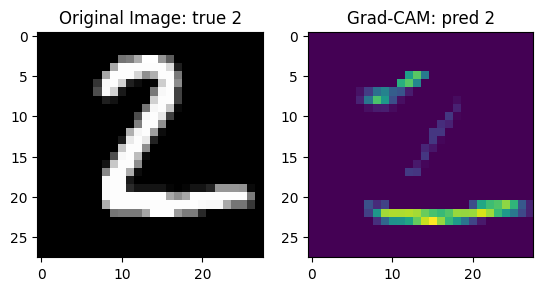

In [144]:
print(np.shape(test_y))
test_idx = 1
test_img = test_x[[test_idx]]
test_true = test_y[test_idx]

layer_idx = 0

heatmap, test_pred = make_gradcam_heatmap(test_img, model, layer_idx)

plt.subplot(1,2,1)
plt.imshow(test_x[[test_idx]].reshape(28,28), cmap='gray')
plt.title(f"Original Image: true {test_true}")
plt.subplot(1,2,2)
plt.imshow(heatmap, cmap='viridis')
plt.title("Grad-CAM")
plt.title(f"Grad-CAM: pred {test_pred}")

plt.show()

In [161]:
def save_and_display_gradcam(img_input, heatmap, test_true, test_pred, 
                             cam_path,  alpha=0.005):
    # Load the original image
    img =img_input.reshape(28,28)
    img = keras.preprocessing.image.img_to_array(img)

    # 정규화된 Heatmap 이미지를 0-255 범위로 변환
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")

    # 계산된 값을 RGB 값으로 변경 및 이미지 변환
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # 계산한 Heatmap과 입력 이미지 결합
    # alpha 값을 통해 입력 이미지의 투명도 계산
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # 생성된 이미지 저장
    superimposed_img.save(cam_path)

    # 가시화
    plt.figure(figsize=(5,5))
    plt.imshow(superimposed_img)
    plt.title(f"Original image with Grad-CAM: true {test_true} | pred {test_pred}")
    plt.show()
    plt.close()

(1000, 28, 28, 1)


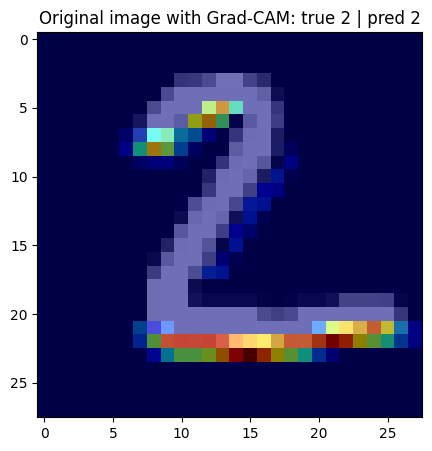

In [162]:
print(np.shape(test_x))

#%%
test_idx = 1
test_img = test_x[[test_idx]]
test_true = test_y[test_idx]

layer_idx = 0

heatmap, test_pred = make_gradcam_heatmap(test_img, model, layer_idx)

# plt.subplot(1,2,1)
# plt.imshow(test_x[[test_idx]].reshape(28,28), cmap='gray')
# plt.title(f"Original Image: true {test_true}")
# plt.subplot(1,2,2)
# plt.imshow(heatmap, cmap='viridis')
# plt.title("Grad-CAM")
# plt.title(f"Grad-CAM: pred {test_pred}")
# plt.show()

#%%
save_and_display_gradcam(test_img, heatmap, test_true, test_pred,
                         cam_path=f'GradCAM_layer{layer_idx}_testidx{test_idx}.png')

In [163]:
list_1 = []
list_7 = []
list_9 = []

for i in range(1000):
    if test_y[i] == 1:
        list_1.append(i)
    if test_y[i] == 7:
        list_7.append(i)
    if test_y[i] == 9:
        list_9.append(i)

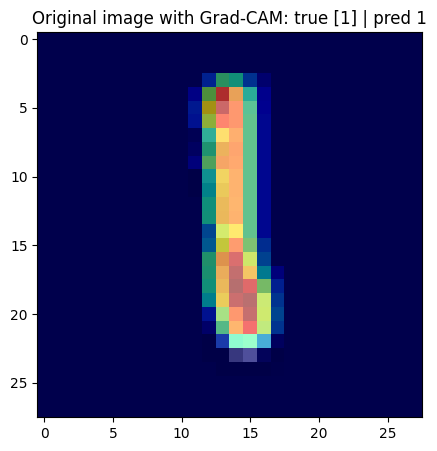

In [171]:
layer_idx = 0
idx = np.random.randint(0, 90)

test_idx_1 = [list_1[idx]]
test_image_1 = test_x[test_idx_1]
test_true_1 = test_y[test_idx_1]

heatmap, test_pred = make_gradcam_heatmap(test_image_1, model, layer_idx)
save_and_display_gradcam(test_image_1, heatmap, test_true_1, test_pred,
                         cam_path=f'GradCAM_layer{layer_idx}_testidx{test_idx_1}.png')

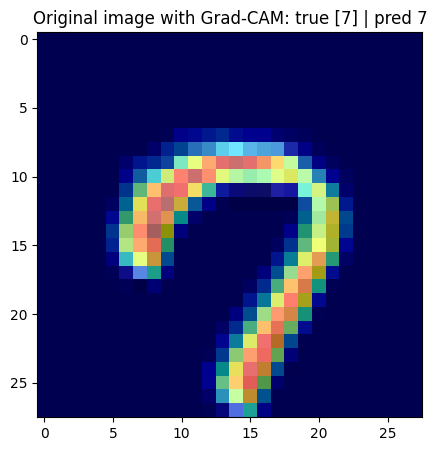

In [169]:
layer_idx = 0
idx = np.random.randint(0, 90)

test_idx_2 = [list_7[idx]]
test_image_2 = test_x[test_idx_2]
test_true_2 = test_y[test_idx_2]

heatmap, test_pred = make_gradcam_heatmap(test_image_2, model, layer_idx)
save_and_display_gradcam(test_image_2, heatmap, test_true_2, test_pred,
                         cam_path=f'GradCAM_layer{layer_idx}_testidx{test_idx_2}.png')

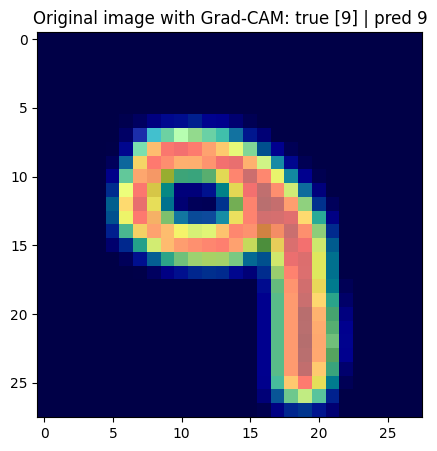

In [172]:
layer_idx = 0
idx = np.random.randint(0, 90)

test_idx_3 = [list_9[idx]]
test_image_3 = test_x[test_idx_3]
test_true_3 = test_y[test_idx_3]

heatmap, test_pred = make_gradcam_heatmap(test_image_3, model, layer_idx)
save_and_display_gradcam(test_image_3, heatmap, test_true_3, test_pred,
                         cam_path=f'GradCAM_layer{layer_idx}_testidx{test_idx_3}.png')

# GradCAM with VGG16

In [1]:
import os
import numpy as np
import random

from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image    import img_to_array, load_img
from tensorflow.keras.applications.vgg16     import (preprocess_input, decode_predictions)

In [2]:
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
set_seeds(42)

In [5]:
# 직접 다운로드
# !wget https://url.kr/argi5c -O 'images.zip'
# !unzip images.zip -d './images'

'wget'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.
'unzip'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [7]:
model_builder = tf.keras.applications.vgg16.VGG16

preprocess_input = keras.applications.vgg16.preprocess_input
decode_predictions = keras.applications.vgg16.decode_predictions

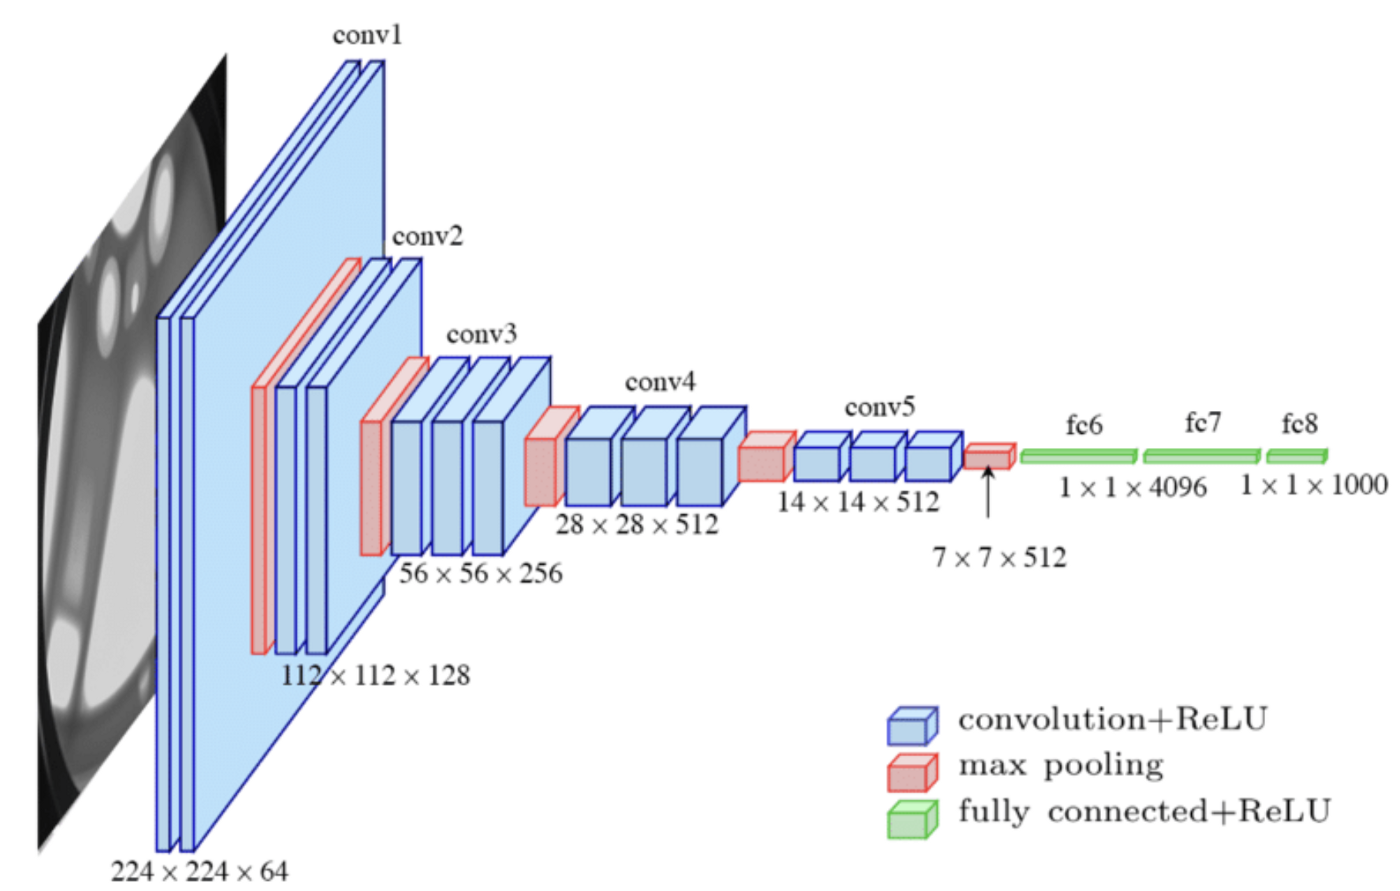

In [12]:
model_builder

<function keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation='softmax')>

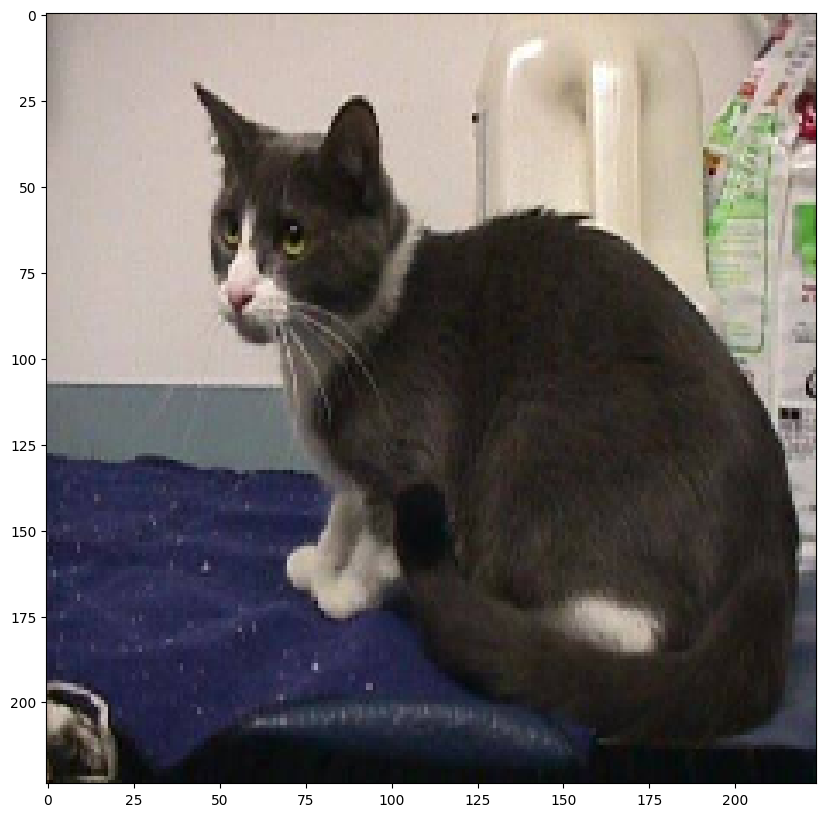

In [11]:
# 이미지 경로
# image_ = load_img('data/cat.1.jpg', target_size=(224, 224))
image_= load_img('./images/cat.1.jpg', target_size=(224, 224))
plt.figure(figsize=(10,10))
plt.imshow(image_)

In [13]:
model = model_builder(weights="imagenet")
model.summary()

553467096/553467096 [==============================] - 149s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                          

In [14]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 [==============================] - 0s 15ms/step
Predicted: [('n02104365', 'schipperke', 0.5914955)]


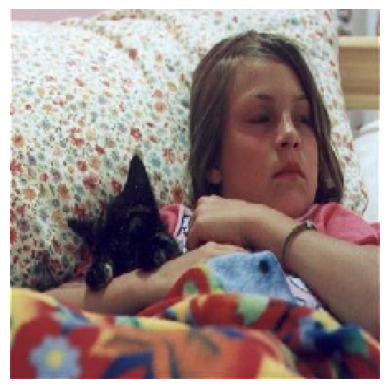

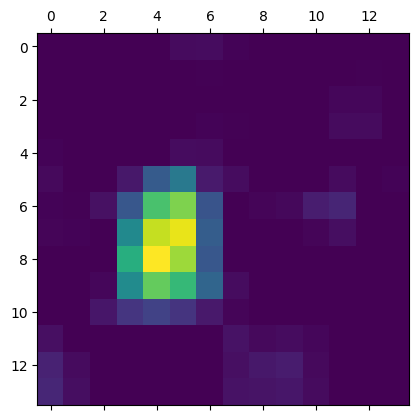

In [18]:
last_conv_layer_name = "block5_conv3"


processed_images = []

image_= load_img('./images/cat.2.jpg', target_size=(224, 224))
plt.imshow(image_)
plt.axis('off')

# 학습에 사용할 이미지를 3차원 배열로 변환 및 전처리하는 코드
# processed_images에는 학습에 사용할 이미지가 들어가게 된다.

image = img_to_array(image_)
image = preprocess_input(image)
processed_images.append(image)
processed_images = np.array(processed_images)


# 모델의 예측 결과 표현
preds = model.predict(processed_images)
print("Predicted:", decode_predictions(preds, top=1)[0])

# 히트맵 생성
heatmap = make_gradcam_heatmap(processed_images, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [19]:
def save_and_display_gradcam(img_, heatmap, cam_path="cam.jpg", alpha=0.4):
   
    img = keras.preprocessing.image.img_to_array(img_)
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

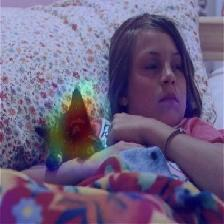

In [20]:
save_and_display_gradcam(image_, heatmap)